Found 4059 files belonging to 9 classes.
Found 1019 files belonging to 9 classes.
Clases disponibles: ['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']


C:\Users\KEVIN\AppData\Local\Temp\ipykernel_26056\1428822242.py:58: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 7s 1us/step
Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.2605 - loss: 2.0557 - val_accuracy: 0.6516 - val_loss: 1.1489 - learning_rate: 1.0000e-04
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.5728 - loss: 1.2264 - val_accuracy: 0.7556 - val_loss: 0.8132 - learning_rate: 1.0000e-04
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.6713 - loss: 0.9768 - val_accuracy: 0.8008 - val_loss: 0.6659 - learning_rate: 1.0000e-04
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.6977 - loss: 0.8758 - val_accuracy: 0.8273 - val_loss: 0.5952 - learning_rate: 1.0000e-04
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.7290 - loss: 0.7843 - val_accuracy: 0.8342 - val_loss: 0.5460 - learning_rate: 1.0000e-04
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.7433 - loss: 0.7452 - val_accuracy: 0.8449 - val_loss: 0.5080 - learning_rate: 1.0000e-04
Epoch 7/5

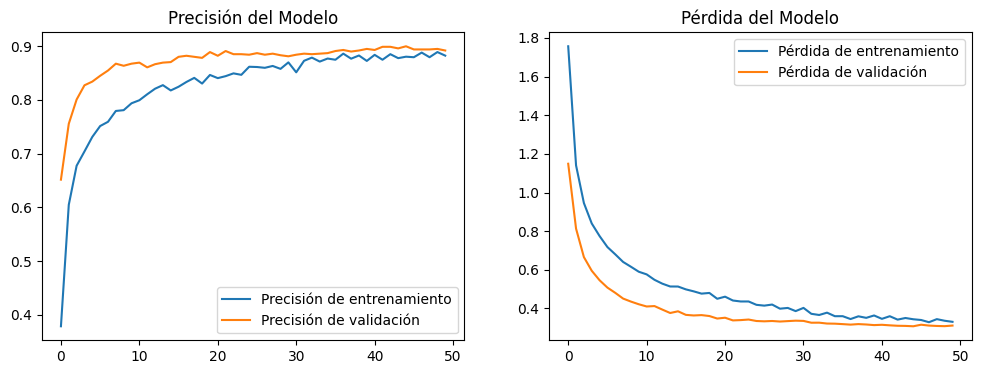

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import shutil

# Ruta del dataset
dataset_directory = os.path.join(os.getcwd(), 'TrashDataset')

# Dividir datos en entrenamiento y validación
def split_data(dataset_directory, train_size=0.8):
    classes = os.listdir(dataset_directory)
    os.makedirs(os.path.join(dataset_directory, 'train'), exist_ok=True)
    os.makedirs(os.path.join(dataset_directory, 'test'), exist_ok=True)
    
    for class_name in classes:
        class_path = os.path.join(dataset_directory, class_name)
        if os.path.isdir(class_path):
            os.makedirs(os.path.join(dataset_directory, 'train', class_name), exist_ok=True)
            os.makedirs(os.path.join(dataset_directory, 'test', class_name), exist_ok=True)
            images = os.listdir(class_path)
            train_images, test_images = train_test_split(images, train_size=train_size, random_state=123)
            for image in train_images:
                shutil.move(os.path.join(class_path, image), os.path.join(dataset_directory, 'train', class_name, image))
            for image in test_images:
                shutil.move(os.path.join(class_path, image), os.path.join(dataset_directory, 'test', class_name, image))

split_data(dataset_directory)

# Cargar datos
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_directory, 'train'), image_size=(256, 256), batch_size=32, label_mode='int', shuffle=True, seed=123
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_directory, 'test'), image_size=(256, 256), batch_size=32, label_mode='int', shuffle=False, seed=123
)

class_names = train_dataset.class_names
print("Clases disponibles:", class_names)

# Normalización y aumentación de datos
normalization_layer = tf.keras.layers.Rescaling(1./255)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
])

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Modelo preentrenado (MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Congelar capas

# Construcción del modelo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

# Compilación del modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Entrenamiento
epochs = 50
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[early_stopping, reduce_lr])

# Evaluación
test_loss, test_acc = model.evaluate(test_dataset)
print("Precisión en test:", test_acc)

# Graficar historia de entrenamiento
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Precisión de entrenamiento')
    plt.plot(epochs_range, val_acc, label='Precisión de validación')
    plt.legend()
    plt.title('Precisión del Modelo')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Pérdida de entrenamiento')
    plt.plot(epochs_range, val_loss, label='Pérdida de validación')
    plt.legend()
    plt.title('Pérdida del Modelo')
    
    plt.show()

plot_history(history)

# Guardado del modelo
model.save('modelo_clasificacion_basuraUltimateN.h5')

# Función de predicción
def predict_image(image_path, model, class_names):
    from tensorflow.keras.preprocessing import image
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    print(f'Clase predicha: {class_names[predicted_class]} con confianza del {confidence * 100:.2f}%')


